# Introduction
in this project we will try to predict the price of a diamond based on the features it have.

## About the data
This classic dataset contains the prices and other attributes of almost 54,000 diamonds. It's a great dataset for beginners learning to work with data analysis and visualization.

## Content
* price in US dollars (\$326--\$18,823)
* carat weight of the diamond (0.2--5.01)
* cut quality of the cut (Fair, Good, Very Good, Premium, Ideal)
* color diamond colour, from J (worst) to D (best)
* clarity a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
* x length in mm
* y width in mm
* z depth in mm
* depth total depth percentage = z / mean(x, y) = 2 * z / (x + y)
* table width of top of diamond relative to widest point

In [74]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

# loading the data

In [75]:
diamonds = pd.read_csv("data/diamonds.csv")
diamonds = diamonds.iloc[:, 1:]
diamonds

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53936,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53937,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53938,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


In [76]:
diamonds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


look's like there is no null values, but lets make sure

In [77]:
diamonds.isna().values.any()

False

## plot the data-distribution

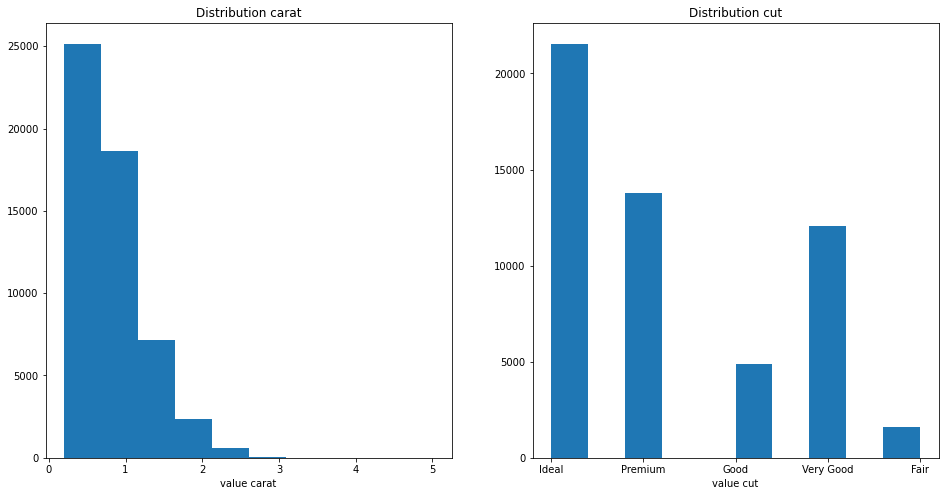

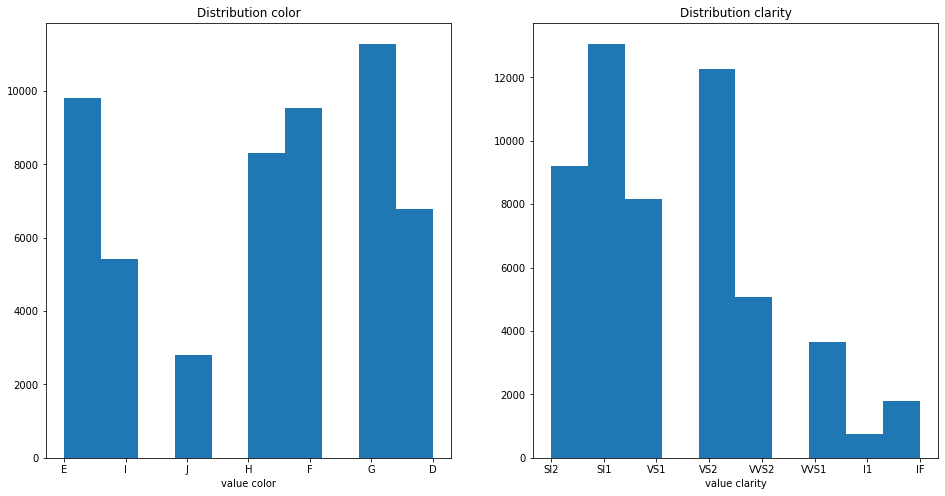

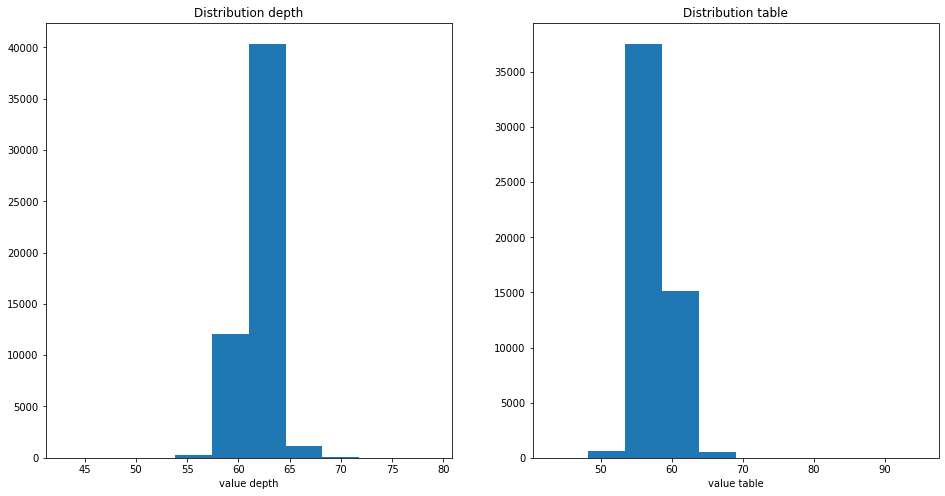

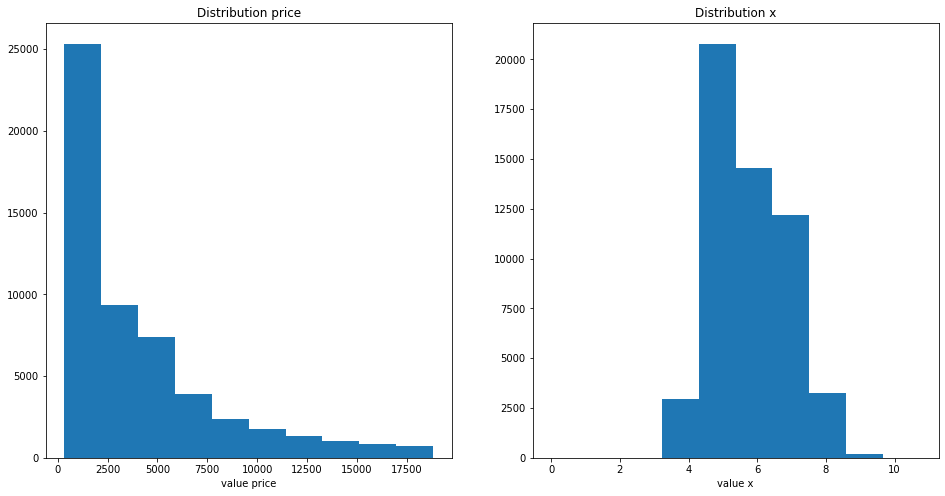

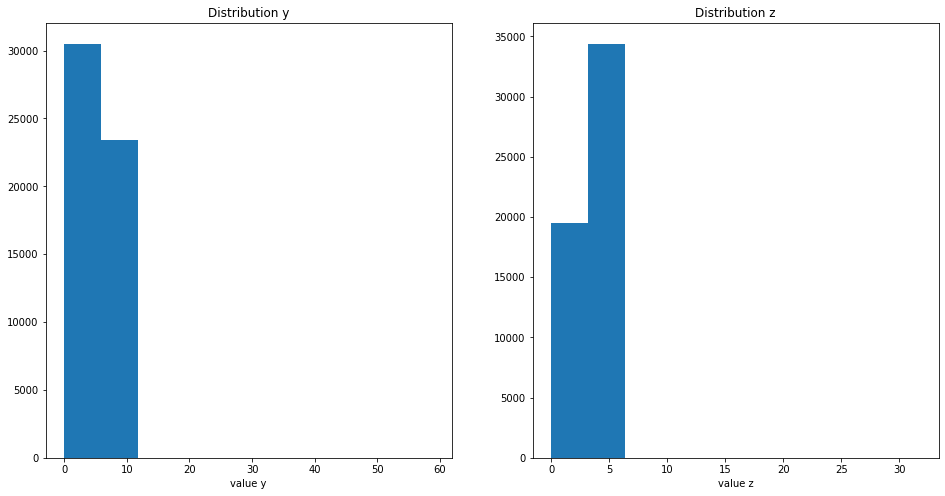

In [78]:
def plot_distribution(df_set : pd.DataFrame):
    fig, ax = None, None
    i = 0
    for column in df_set.columns:
        if i == 0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
        ax[i].hist(df_set[column])
        ax[i].title.set_text(("Distribution " + column))
        ax[i].set_xlabel("value " + column)
        if i == 1:
            plt.show()

            i = 0
        else:
            i += 1

plot_distribution(diamonds)

## clearly we need to change the "categorical" data into ordinal.
we can also see that the distribution of  carat and price are about the same.

## Let's take a look at the column's and the "mean" price.

In [79]:
from IPython.display import display, HTML

def group_range(data_set : pd.DataFrame, col : str, folds = 5):
    min_v = data_set[col].min()
    max_v = data_set[col].max()
    folds = (max_v - min_v) / folds
    print(min_v, max_v, folds)
    return data_set.groupby(pd.cut(data_set[col], np.arange(min_v, max_v, folds))).mean()


def get_dfs(df_set : pd.DataFrame, compare : str):
    for col in df_set.columns:
        if col == compare:
            continue
        current_df = df_set[[col, compare]]
        display(current_df.groupby([col]).mean().sort_values(by=([compare]),ascending=False))

diamonds_range = diamonds.copy()

def convert_to_ranges(df_set : pd.DataFrame, columns : []):
    df_copy = df_set.copy()
    for col in columns:
        range_data = group_range(df_copy, col)["price"].sort_values(ascending=False).reset_index().dropna()
        display(range_data)
    return df_copy.drop(columns, axis=1)


range_map = ["carat", "table", "depth", "x", "y", "z"]
diamonds_range = convert_to_ranges(diamonds_range, range_map)

get_dfs(diamonds_range, "price")
#company_df = df[["company","rating"]]

#company_df.groupby(['company']).mean().sort_values(by=(["rating"]),ascending=False)[:10]

0.2 5.01 0.962
43.0 95.0 10.4
43.0 79.0 7.2
0.0 10.74 2.148
0.0 58.9 11.78
0.0 31.8 6.36


,carat,price
0,"(2.124, 3.086]",15183.928036
1,"(3.086, 4.048]",14201.000000
2,"(1.162, 2.124]",9961.803229
3,"(0.2, 1.162]",2453.222486


,table,price
0,"(63.8, 74.2]",4220.948805
1,"(53.4, 63.8]",3936.952392
2,"(43.0, 53.4]",3343.346269
3,"(74.2, 84.6]",2331.500000


,depth,price
0,"(64.6, 71.8]",4482.773960
1,"(43.0, 50.2]",4032.000000
2,"(57.4, 64.6]",3921.985164
3,"(50.2, 57.4]",3835.341772


,x,price
0,"(6.444, 8.592]",8645.678047
1,"(4.296, 6.444]",2083.399179
2,"(2.148, 4.296]",578.340150


,y,price
0,"(0.0, 11.78]",3932.035972
1,"(23.56, 35.34]",2075.000000


,z,price
0,"(6.36, 12.72]",15551.200000
1,"(0.0, 6.36]",3929.951942


,price
cut,
Premium,4584.257704
Fair,4358.757764
Very Good,3981.759891
Good,3928.864452
Ideal,3457.541970


,price
color,
J,5323.818020
I,5091.874954
H,4486.669196
G,3999.135671
F,3724.886397
D,3169.954096
E,3076.752475


,price
clarity,
SI2,5063.028606
SI1,3996.001148
VS2,3924.989395
I1,3924.168691
VS1,3839.455391
VVS2,3283.737071
IF,2864.839106
VVS1,2523.114637


## Anomalies
we were told that I1 is the worst clarity,
yet it doesn't have the lowest mean price,
same with color, and cut

while cut is the worst case as Ideal supposed to be the best yet it's actually the worst price,
so in this case I will assume "ideal" is actually the worst!

## Let's look at correlations

In [80]:
diamonds.corr()["price"]

carat    0.921591
depth   -0.010647
table    0.127134
price    1.000000
x        0.884435
y        0.865421
z        0.861249
Name: price, dtype: float64

we can see there is a high correlation between carat, x, y, z and price.
maybe we can make an accurate prediction with just those?

## first try.
lets for now drop the object values,
and use cross validation to see how good our initial model is.

let's try a KNN and linear-regression model

In [81]:
diamonds_copy = diamonds.select_dtypes(['number'])
diamonds_copy


# plt.hist(diamonds_copy["price"])
# plt.title('Distribution X')
# plt.xlabel('price')
# plt.show()

,carat,depth,table,price,x,y,z
0,0.23,61.5,55.0,326,3.95,3.98,2.43
1,0.21,59.8,61.0,326,3.89,3.84,2.31
2,0.23,56.9,65.0,327,4.05,4.07,2.31
3,0.29,62.4,58.0,334,4.20,4.23,2.63
4,0.31,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...
53935,0.72,60.8,57.0,2757,5.75,5.76,3.50
53936,0.72,63.1,55.0,2757,5.69,5.75,3.61
53937,0.70,62.8,60.0,2757,5.66,5.68,3.56
53938,0.86,61.0,58.0,2757,6.15,6.12,3.74


## Build a quick testing algorithm
we will use the "run_cross_val" function everytime we want to compare changes

In [116]:
from sklearn.metrics import mean_squared_error
def split_x_y(data_set):
    return data_set.drop('price', axis = 1), data_set['price']

def display_scores(m_scores):
    sqrt_scores = np.sqrt(-m_scores)
    print("Scores:", sqrt_scores)
    print("Mean:", sqrt_scores.mean())
    print("Standard deviation:", sqrt_scores.std())

def run_cross_val(data_set : pd.DataFrame, test_model, pipe, name : str = None):
    if name is None:
        print(test_model)
    else:
        print(name, test_model)
    train_set_r, test_set_r = train_test_split(data_set, test_size = 0.2, random_state = 2)
    x_train_r, y_train_r = split_x_y(train_set_r)

    x_train_copy_r = pipe.fit_transform(x_train_r)
    scores_r = cross_val_score(test_model, x_train_r, y_train_r, scoring="neg_mean_squared_error", cv = 10)

    display_scores(scores_r)

    train_set_r2, test_set_r2 = train_test_split(train_set_r, test_size = 0.1, random_state = 2)
    x_train_r2, y_train_r2 = split_x_y(train_set_r2)
    x_test_r2, y_test_r2 = split_x_y(test_set_r2)
    print("")
    print("---- prediction overlook ----")
    x_train_copy_r2 = pipe.fit_transform(x_train_r2)
    test_model.fit(x_train_copy_r2, y_train_r2)
    x_test_r2_copy = pipe.transform(x_test_r2)
    pred_model = test_model.predict(x_test_r2_copy)
    print(pred_model[:10])
    print(list(y_test_r2[:10]))

    print(len(y_test_r2), len(pred_model))
    model_mse = mean_squared_error(y_test_r2, pred_model)
    model_rmse = np.sqrt(model_mse)
    print("rmse :", model_rmse)
    print("original mean : ", y_test_r2.mean(), "original std:", y_test_r2.std())
    print("predicted mean : ", pred_model.mean(), "predicted std:", pred_model.std())
    print()

def run_cross_val_scores(data_set : pd.DataFrame, test_model, pipe, name : str = None):
    train_set_r, test_set_r = train_test_split(data_set, test_size = 0.2, random_state = 2)
    x_train_r, y_train_r = split_x_y(train_set_r)

    x_train_copy_r = pipe.fit_transform(x_train_r)
    scores_r = cross_val_score(test_model, x_train_r, y_train_r, scoring="neg_mean_squared_error", cv = 10)
    return scores_r

In [83]:
scalar = StandardScaler()
knn_model = KNeighborsRegressor(n_neighbors=10)
linear_model = LinearRegression()

run_cross_val(diamonds_copy, knn_model, scalar)

run_cross_val(diamonds_copy, linear_model, scalar)

KNeighborsRegressor(n_neighbors=10)
Scores: [1401.4600222  1427.55962772 1465.83243732 1415.78396493 1409.21006541
 1467.99466341 1405.8850837  1360.7167779  1370.48782653 1424.14311078]
Mean: 1414.907357990017
Standard deviation: 32.95781904664221

---- prediction overlook ----
[1960.7  754.6 4125.5  786.5 1789.3 6126.6 1273.3 3671.8  590.6  572.2]
[2501, 628, 3794, 1007, 1847, 4120, 1374, 3004, 802, 574]
4316 4316
rmse : 1375.3890767074704
original mean :  3874.7235866543097 original std: 3926.135784778573
predicted mean :  3922.1893883225207 predicted std: 3797.026998414679

LinearRegression()
Scores: [1494.93466631 1507.18401946 1536.39608042 1465.86615708 1493.1369719
 1530.12439001 1506.38424958 1490.04995202 1432.29234835 1547.23315585]
Mean: 1500.3601990972843
Standard deviation: 32.365727920781715

---- prediction overlook ----
[2535.80645811  514.02149569 4445.78095362  719.49134336 2122.02432351
 5590.26362801 1164.33928031 3926.21743915  234.36008273  197.86961822]
[2501, 6

## Error mean of 1500
well even without the "categorical" data we can predict the price of the diamond to quite a good extend.
<br> considering that the STD of price is about 4k a mean error of 1.5k is quite GOOD!
then again we threw a lot of useful data that can improve our prediction even more!

## Fixing features
next we will transform our feature's to be useful
for instance we can change the "cut" values to be represented by numbers!
same thing for the other columns.

In [103]:
diamonds_c_object = diamonds.select_dtypes(include=['object']).copy()
for column in diamonds_c_object.columns:
    print(column, diamonds_c_object[column].unique())

cut_map = {
    'Fair' : 11, 'Good' : 12,
    'Very Good' : 13, 'Premium' : 14, 'Ideal' : 10
}

color_map = {
    'J' : 1, 'I' : 2, 'H' : 3, 'G' : 4,
    'F' : 5, 'E' : 6, 'D' : 7,
}

## (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
clarity_map = {
    'I1' : 1, 'SI2' : 2, 'SI1' : 3, 'VS2' : 4, 'VS1' : 5,
    'VVS2' : 6, 'VVS1' : 7, 'IF' : 8
}

all_map = {
    'cut' : cut_map,
    'color' : color_map,
    'clarity' : clarity_map
}

diamonds_all = diamonds.replace(all_map)
diamonds_all

cut ['Ideal' 'Premium' 'Good' 'Very Good' 'Fair']
color ['E' 'I' 'J' 'H' 'F' 'G' 'D']
clarity ['SI2' 'SI1' 'VS1' 'VS2' 'VVS2' 'VVS1' 'I1' 'IF']


,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,10,6,2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,14,6,3,59.8,61.0,326,3.89,3.84,2.31
2,0.23,12,6,5,56.9,65.0,327,4.05,4.07,2.31
3,0.29,14,2,4,62.4,58.0,334,4.20,4.23,2.63
4,0.31,12,1,2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,10,7,3,60.8,57.0,2757,5.75,5.76,3.50
53936,0.72,12,7,3,63.1,55.0,2757,5.69,5.75,3.61
53937,0.70,13,7,3,62.8,60.0,2757,5.66,5.68,3.56
53938,0.86,14,3,2,61.0,58.0,2757,6.15,6.12,3.74


## print the current correlations!

In [104]:
diamonds_all.corr()["price"]

carat      0.921591
cut        0.105297
color     -0.172511
clarity   -0.146800
depth     -0.010647
table      0.127134
price      1.000000
x          0.884435
y          0.865421
z          0.861249
Name: price, dtype: float64

<AxesSubplot:>

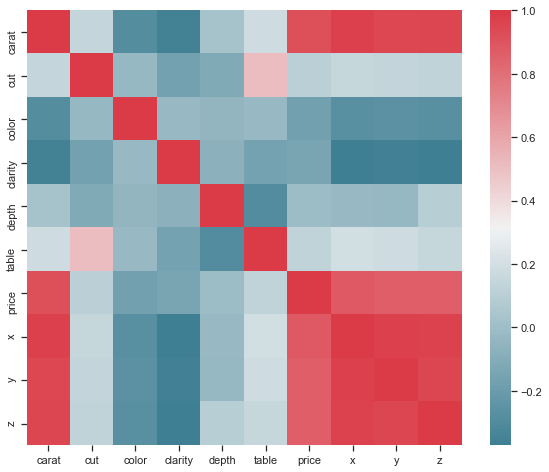

In [105]:
import seaborn as sns

f, ax = plt.subplots(figsize=(10, 8))
corr = diamonds_all.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

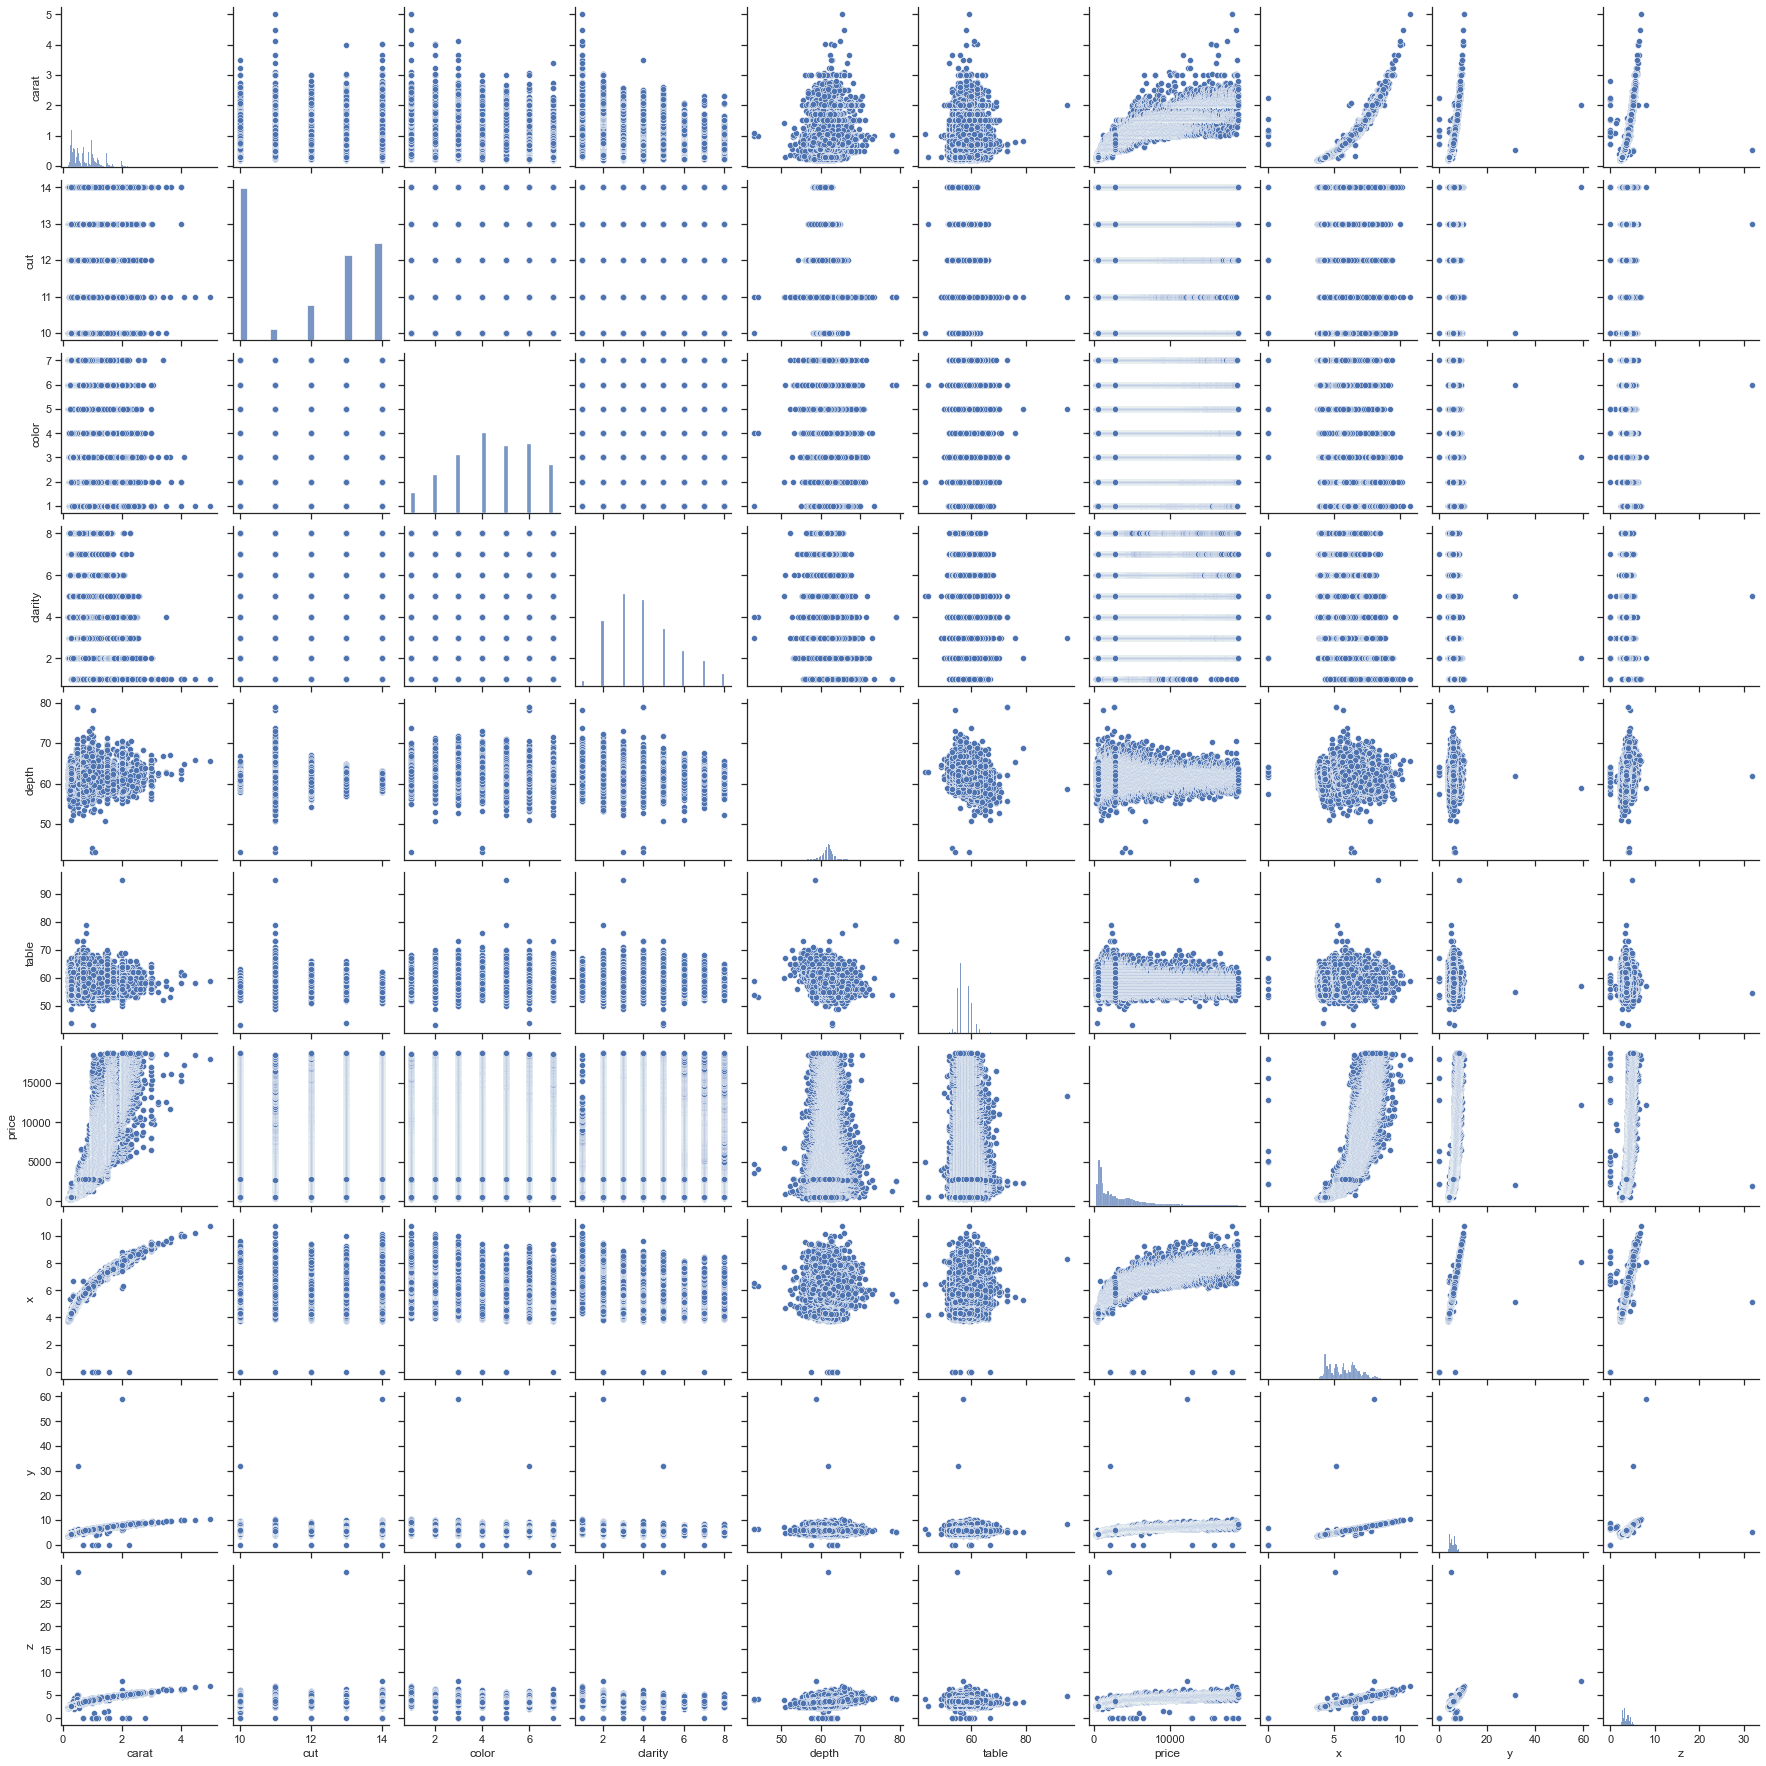

In [106]:
sns.set_theme(style="ticks")

sns.pairplot(diamonds_all)

## overlook

we can clearly see that the main "features" that define,
the diamond price are x,y,z and carat, while the other have a low correlation.

In [108]:
scalar = StandardScaler()
knn_model = KNeighborsRegressor(n_neighbors=10)
linear_model = LinearRegression()

diamonds_all_copy = diamonds_all.copy()
run_cross_val(diamonds_all_copy, knn_model, scalar)

run_cross_val(diamonds_all_copy, linear_model, scalar)

KNeighborsRegressor(n_neighbors=10)
Scores: [895.65764643 848.46633412 875.66887939 865.90354062 906.18526942
 924.9806101  834.21218259 865.77824638 859.06477498 847.88162441]
Mean: 872.3799108453056
Standard deviation: 27.118121205030977

---- prediction overlook ----
[2727.9  564.7 3335.9  945.7 1824.9 4423.4 1142.2 3524.9  789.7  558.8]
[2501, 628, 3794, 1007, 1847, 4120, 1374, 3004, 802, 574]
4316 4316
rmse : 707.8096920614248
original mean :  3874.7235866543097 original std: 3926.135784778573
predicted mean :  3883.7517608897124 predicted std: 3836.5230223967283

LinearRegression()
Scores: [1241.20300829 1240.29300185 1228.38369816 1174.95935708 1243.33545143
 1240.20926878 1229.56999918 1204.58004018 1183.28538143 1269.27283109]
Mean: 1225.5092037466588
Standard deviation: 27.775707224946807

---- prediction overlook ----
[3888.53620003 -577.88970571 3103.43765185 1424.32529264 2238.52764003
 4623.1639825  2020.02261617 3576.00068604  135.84369574 -488.56085955]
[2501, 628, 3794

## Huge improvement
the mean Error is about twice lower!

## Picking best model
let's run a few more models, and pick the best one

In [112]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

model_forest = RandomForestRegressor(random_state=41, n_estimators=100, n_jobs=-1)
model_tree = DecisionTreeRegressor(random_state=42)

run_cross_val(diamonds_all_copy, model_tree, scalar)
run_cross_val(diamonds_all_copy, model_forest, scalar)

DecisionTreeRegressor(random_state=42)
Scores: [757.59461263 733.00641413 757.50554205 743.9630255  753.46689586
 808.91935611 740.56992819 719.15816717 746.19075622 767.48405198]
Mean: 752.7858749829726
Standard deviation: 22.815530980561157

---- prediction overlook ----
[2469.  628. 3578.  724. 1825. 3796. 1097. 2890.  802.  574.]
[2501, 628, 3794, 1007, 1847, 4120, 1374, 3004, 802, 574]
4316 4316
rmse : 745.3183611405245
original mean :  3874.7235866543097 original std: 3926.135784778573
predicted mean :  3894.744670991659 predicted std: 3966.508932148118

RandomForestRegressor(n_jobs=-1, random_state=41)
Scores: [562.98926651 549.94633822 547.49649959 552.57880094 565.55566098
 571.71437826 517.13650964 505.99385187 536.60588158 532.39542077]
Mean: 544.2412608367866
Standard deviation: 20.1726978536517

---- prediction overlook ----
[2357.01  628.81 3646.02  879.98 1801.7  4095.75 1084.21 3219.27  730.68
  570.1 ]
[2501, 628, 3794, 1007, 1847, 4120, 1374, 3004, 802, 574]
4316 4316

In [123]:
best_model = None
best_i = 0
best_score = float("inf")
best_scores = None

for i in range(2, 10, 1):
    knn_model = KNeighborsRegressor(n_neighbors=i)

    scores = run_cross_val_scores(diamonds_all_copy, knn_model, scalar)
    scores = np.sqrt(-scores)
    if scores.mean() < best_score:
        best_model = knn_model
        best_score = scores.mean()
        best_scores = -scores

print("best model :")
print(best_model)
display_scores(best_scores)

best model :
KNeighborsRegressor(n_neighbors=8)
Scores: [29.97321929 29.19793421 29.68933088 29.41589929 30.11981306 30.40865166
 28.89218009 29.40996768 29.2581388  29.18358941]
Mean: 29.554872438737686
Standard deviation: 0.4554084918471051


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
                               n_iter = 100, cv = 3, verbose=2, random_state=42,
                               n_jobs = -1)

train_set, test_set = train_test_split(diamonds_all_copy, test_size = 0.2, random_state = 2)
x_test, y_test = split_x_y(test_set)
x_train, y_train = split_x_y(train_set)

X = scalar.fit_transform(x_train)

rf_random.fit(X, y_train)
print(rf_random.best_score_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [88]:
train_set, test_set = train_test_split(diamonds_copy, test_size = 0.2, random_state = 2)
x_test, y_test = split_x_y(test_set)
x_train, y_train = split_x_y(train_set)

model = KNeighborsRegressor(n_neighbors=10)
X = scalar.fit_transform(x_train)
model.fit(X, y_train)

X = scalar.transform(x_test)

plot_confusion_matrix(model, X, y_test)
plt.show()

ValueError: plot_confusion_matrix only supports classifiers